Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dimensiones del dataset: (9343, 15)

Primeras 5 filas del dataset:

Primeras 5 filas del dataset codificado:


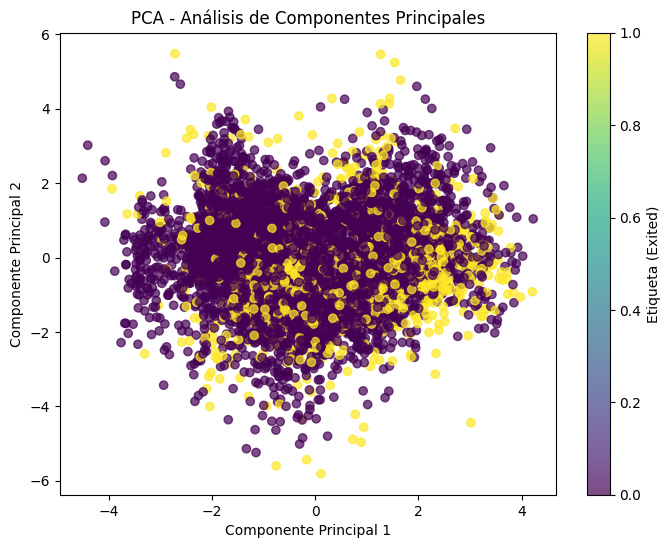

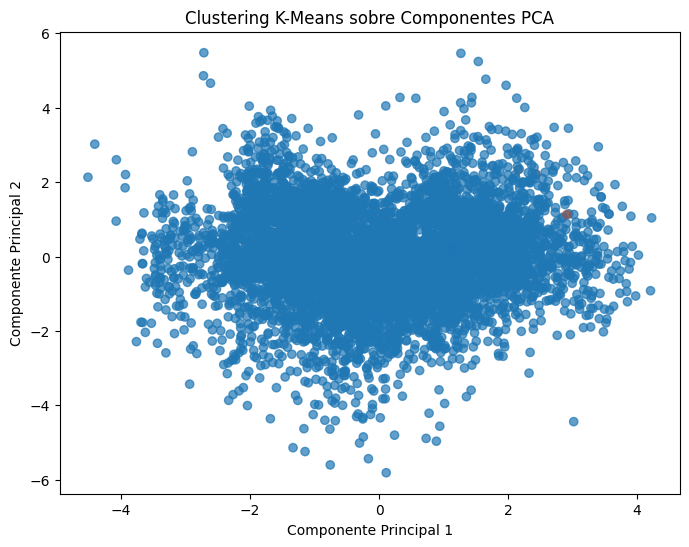

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:31:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Precisión en el conjunto de entrenamiento: 89.83%
Precisión en el conjunto de prueba: 86.55%

Reporte de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2266
           1       0.75      0.45      0.56       537

    accuracy                           0.87      2803
   macro avg       0.82      0.71      0.74      2803
weighted avg       0.86      0.87      0.85      2803


Matriz de confusión:
[[2187   79]
 [ 298  239]]


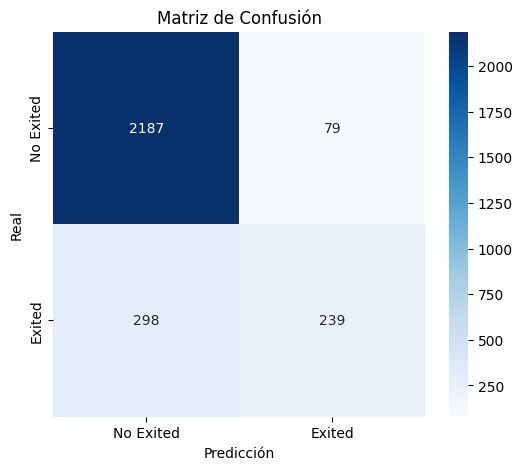

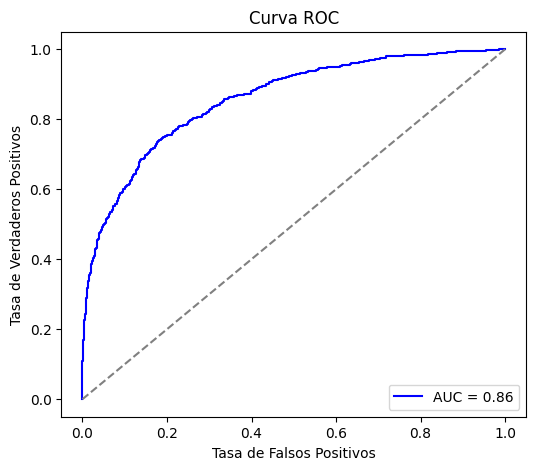

<ipython-input-21-4473ac9cfc51>:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=np.array(X_data.columns)[indices_model], x=importances_model[indices_model], palette="viridis")


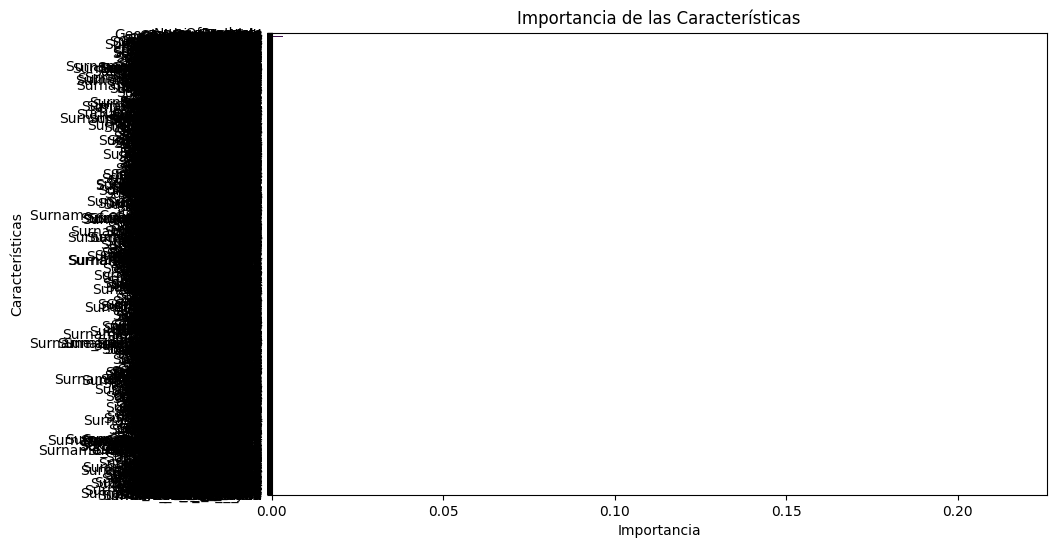

<ipython-input-21-4473ac9cfc51>:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, palette="viridis")


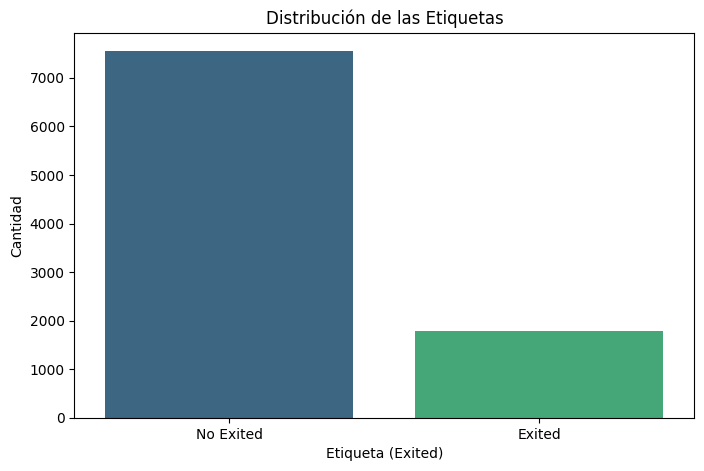

Done


In [21]:
# Proyecto 02
# Aranza Moreira

from google.colab import drive
drive.mount('/content/drive')

# dataset limpio
import pandas as pd
ruta_archivo = '/content/drive/MyDrive/Colab Notebooks/cleaned_dataset.csv'
dataset = pd.read_csv(ruta_archivo)


print("Dimensiones del dataset:", dataset.shape)
print("\nPrimeras 5 filas del dataset:")
dataset.head()

# Conversión de variables categóricas a numéricas
dataset_encoded = pd.get_dummies(dataset, drop_first=True)


print("\nPrimeras 5 filas del dataset codificado:")
dataset_encoded.head()

#  dataset en características (X) y etiquetas (y)
X_data = dataset_encoded.drop(columns=['Exited'])  # columna objetivo
y_data = dataset_encoded['Exited']

# conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(
    X_data, y_data, test_size=0.3, random_state=42, stratify=y_data
)

# Preprocesamiento para PCA y K-Means
from sklearn.preprocessing import StandardScaler
scaler_model = StandardScaler()
X_scaled_data = scaler_model.fit_transform(X_train_data)


from sklearn.decomposition import PCA
pca_model = PCA(n_components=2, random_state=42)
pca_results = pca_model.fit_transform(X_scaled_data)

# Gráfica de componentes principales
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=y_train_data, cmap='viridis', alpha=0.7)
plt.colorbar(label='Etiqueta (Exited)')
plt.title('PCA - Análisis de Componentes Principales')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

# K-Means- agrupamiento de datos
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=3, random_state=42)
cluster_results = kmeans_model.fit_predict(X_scaled_data)

# Gráfica de  clusters  por K-Means
plt.figure(figsize=(8, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=cluster_results, cmap='tab10', alpha=0.7)
plt.title('Clustering K-Means sobre Componentes PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

# Construcción pipeline
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

xgboost_pipeline = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        random_state=42,
        n_estimators=500,
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=1,
        subsample=0.9,
        colsample_bytree=0.8,
        gamma=0,
        scale_pos_weight=1,
        use_label_encoder=False,
        eval_metric="logloss"
    )
)

# Entrenamiento del modelo con el conjunto de train
xgboost_pipeline.fit(X_train_data, y_train_data)

# Evaluación de moelo
train_accuracy_model = xgboost_pipeline.score(X_train_data, y_train_data)
test_accuracy_model = xgboost_pipeline.score(X_test_data, y_test_data)

print(f"Precisión en el conjunto de entrenamiento: {train_accuracy_model:.2%}")
print(f"Precisión en el conjunto de prueba: {test_accuracy_model:.2%}")

# Predicciones del conjunto prueba
y_pred_model = xgboost_pipeline.predict(X_test_data)
y_prob_model = xgboost_pipeline.predict_proba(X_test_data)[:, 1]

# Reporte de clasificación
from sklearn.metrics import classification_report
print("\nReporte de clasificación (conjunto de prueba):")
print(classification_report(y_test_data, y_pred_model))

# Matriz de confusión
from sklearn.metrics import confusion_matrix
conf_matrix_model = confusion_matrix(y_test_data, y_pred_model)
print("\nMatriz de confusión:")
print(conf_matrix_model)

# Visualización de la matriz de confusión
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_model, annot=True, fmt='d', cmap='Blues', xticklabels=["No Exited", "Exited"], yticklabels=["No Exited", "Exited"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva
from sklearn.metrics import roc_curve, roc_auc_score
fpr_model, tpr_model, thresholds_model = roc_curve(y_test_data, y_prob_model)
roc_auc_model = roc_auc_score(y_test_data, y_prob_model)

plt.figure(figsize=(6, 5))
plt.plot(fpr_model, tpr_model, color='blue', label=f'AUC = {roc_auc_model:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc="lower right")
plt.show()

# Importancia de las características
import numpy as np
importances_model = xgboost_pipeline.named_steps['xgbclassifier'].feature_importances_
indices_model = np.argsort(importances_model)[::-1]

# Gráfica
plt.figure(figsize=(10, 6))
sns.barplot(y=np.array(X_data.columns)[indices_model], x=importances_model[indices_model], palette="viridis")
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Distribución de las etiquetas
plt.figure(figsize=(8, 5))
sns.countplot(x=y_data, palette="viridis")
plt.title('Distribución de las Etiquetas')
plt.xlabel('Etiqueta (Exited)')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ["No Exited", "Exited"])
plt.show()

# Exportación del modelo
import joblib

# pipeline completo
joblib.dump(xgboost_pipeline, '/content/drive/MyDrive/Colab Notebooks/pipeline_completo_XGBoost_v2.pkl')
print("Done")
